In [2]:
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("DifferentialEquations")
Pkg.add("Optimization")
Pkg.add("OptimizationOptimJL")
Pkg.add("OptimizationBBO")
Pkg.add("DiffEqParamEstim")
Pkg.add("StatsBase")
Pkg.add("SciMLSensitivity")

    Updating registry at `C:\Users\elbak\.julia\registries\General.toml`
   Resolving package versions...
   Installed SentinelArrays ───── v1.4.8
   Installed WeakRefStrings ───── v1.4.2
   Installed PooledArrays ─────── v1.4.3
   Installed WorkerUtilities ──── v1.6.1
   Installed InlineStrings ────── v1.4.3
   Installed FilePathsBase ────── v0.9.24
   Installed TranscodingStreams ─ v0.11.3
   Installed CodecZlib ────────── v0.7.8
   Installed CSV ──────────────── v0.10.15
    Updating `C:\Users\elbak\.julia\environments\v1.11\Project.toml`
  [336ed68f] + CSV v0.10.15
    Updating `C:\Users\elbak\.julia\environments\v1.11\Manifest.toml`
  [336ed68f] + CSV v0.10.15
  [944b1d66] + CodecZlib v0.7.8
  [34da2185] + Compat v4.16.0
  [9a962f9c] + DataAPI v1.16.0
  [e2d170a0] + DataValueInterfaces v1.0.0
  [48062228] + FilePathsBase v0.9.24
  [842dd82b] + InlineStrings v1.4.3
  [82899510] + IteratorInterfaceExtensions v1.0.0
  [2dfb63ee] + PooledArrays v1.4.3
  [91c51154] + SentinelArrays v1.

In [3]:
# Here are all the packages I used
using StatsBase
using CSV
using Plots
using DataFrames
using DifferentialEquations
using SciMLSensitivity
using LsqFit
using DifferentialEquations, RecursiveArrayTools, Plots, DiffEqParamEstim
using Optimization, ForwardDiff, OptimizationOptimJL, OptimizationBBO

# Label your file names Here I have labelled my resistent cells, my naive cells and the treated resistent cells, and resistent naive cells
# I recommend labelling with very easy names 
data_file = test_set.CSV

LoadError: ArgumentError: Package LsqFit not found in current path.
- Run `import Pkg; Pkg.add("LsqFit")` to install the LsqFit package.

In [5]:

df = CSV.read("test_set.csv", DataFrame)

x = []  # Will store day numbers
y = []  # Will store day averages

current_day = 1
for row in eachrow(df)
    day_average = row[:"Day Averages"]
    if !ismissing(day_average) && !isempty(strip(string(day_average)))
        push!(x, current_day)
        push!(y, day_average)
        current_day += 1
    end
end

println("These are the x data points: ", x)
println("These are the y data points: ", y)

These are the x data points: Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
These are the y data points: Any[0.4709580256245476, 7.315235706296095, 8.550190494375578, 16.57005647276504, 30.309163109227434, 48.20259386940689, 69.90000793980757, 82.76009859630409, 91.54438006349315, 96.63891012736003, 100.09285362559763, 98.37769704564076]


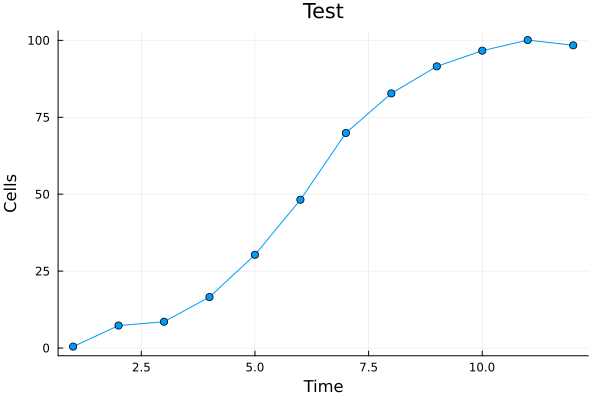

In [6]:
p = plot(x, y, #THESE ARE THE LISTS
     title="Test", 
     xlabel="Time", 
     ylabel="Cells", 
     marker=:circle, 
     line=:solid,
     legend=false)

display(p)

I find it very useful to plot all your data so you understand what it looks like. This is my version of this. 

In [ ]:
function f_withoutD(du, u, p, t)
    r, k, d = p
    du[1] = u[1] * r * (1 - u[1] / k) #THIS JUST DISPLAY THE DIFF EQ
end

solver = Tsit5() #THIS IS THE SOLVER OF CHOICE NOTE THAT THIS IS A LOCAL VERSION AND MAY NOT WORK AS WELL
start, stop = 1.0, 10.0 #make sure to update to your range of values
tspan = (start, stop)
u0 = [y[1]] #This is the initial point, usually the first data point
p = [0.5, maximum(y), 0.5] #I have three paramete

println("Print the tspan: ", tspan)
println("This is your starting condition: ", u0)
println("This is the set of parameters: ", p)

Print the tspan: (1.0, 10.0)
This is your starting condition: [102.0702381]
This is the set of parameters: [0.5, 4022.995833, 0.5]


In [26]:
prob = ODEProblem(f_withoutD, u0, tspan, p)  # Declare initial problem
println("This is what the problem looks like: ", prob)

This is what the problem looks like: ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(f_withoutD), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}(ODEFunction{true, SciMLBase.AutoSpecialize, typeof(f_withoutD), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}(f_withoutD, LinearAlgebra.UniformScaling{Bool}(true), nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, SciMLBase.DEFAULT_OBSERVED, nothing, nothing, nothing, nothing), [102.0702381], (1.0, 10.0), [0.5, 4022.9958

In [27]:
sol = solve(prob, Tsit5(), saveat=x)  # Solve the ODE
println("This is what the solution x values look like: ", sol.t)
println("This is what the solution y values of sol(2) look like: ", sol[2])

This is what the solution x values look like: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
This is what the solution y values of sol(2) look like: [165.56037548720528]


In [ ]:
#This is basically just a loss function like a RSS solver. I try to bake in settings to the package so you do not have to deal with this too much. 
cost_function = build_loss_objective(prob, solver, L2Loss(x, y), Optimization.AutoForwardDiff(), maxiters=10000, verbose=false)  # Define the cost function
println("Feel free to print this but it looks like non-sense")

Feel free to print this but it looks like non-sense


In [ ]:
#This is for producing the optimal problem that you can extract information from
optprob = Optimization.OptimizationProblem(cost_function, p)  # Define the optimization problem
println("This is what the solution x optprob looks like: ", optprob[1])

This is what the solution x optprob looks like: 0.5


In [ ]:
#This produces the x and y list in which you can access the data
optsol = solve(optprob, BFGS())  # Solve the optimization problem
println("This is what the solution x(2) optsol looks like: ", optsol[2])

This is what the solution x(2) optsol looks like: 4429.69798783949


In [ ]:
#Here the are the minimal parameters for a given model
optimized_params = optsol.minimizer  # Access optimized parameters
println("This is what the solution optparams looks like: ", optimized_params)

This is what the solution optparams looks like: [0.7528740060871077, 4429.69798783949, 0.5]


In [ ]:
#THIS IS a creation of the optimized problem
optimized_prob = ODEProblem(f_withoutD, [y[1]], tspan, optimized_params)  # New ODE problem with optimized parameters
println("This is what the solution x(2) optsol looks like: ", optimized_prob)

This is what the solution x(2) optsol looks like: ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(f_withoutD), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}(ODEFunction{true, SciMLBase.AutoSpecialize, typeof(f_withoutD), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}(f_withoutD, LinearAlgebra.UniformScaling{Bool}(true), nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, SciMLBase.DEFAULT_OBSERVED, nothing, nothing, nothing, nothing), [102.0702381], (1.0, 10.0), [0

In [ ]:
#if you notice that your graph looks very choppy you can expand your x data set
xdata_dense = range(x[1], x[end], length=1000)  # 1000 points in range
println(xdata_dense)

1.0:0.008008008008008008:9.0


In [ ]:
#Here is the creation of the optimized solution with more x valeus
optimized_sol = solve(optimized_prob, solver, reltol=1e-15, abstol=1e-15, saveat=xdata_dense)  # Solve with optimized parameters
println("This is the optimized solution: ", optimized_sol[2])
#NOTE THAT EACH OF THE NUMBERS IS A Y Points



This is the optimized solution: [102.67317385750916]


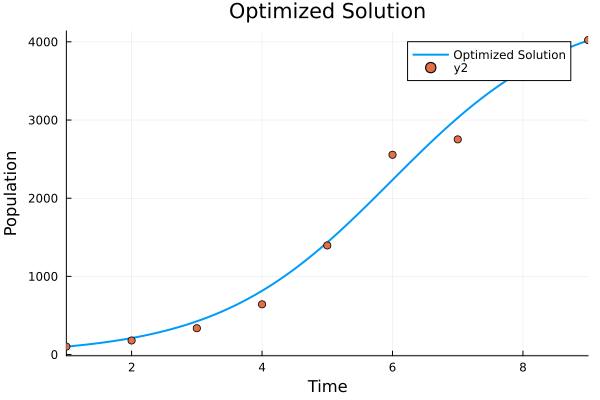

In [43]:
# Create the plot
p = plot(optimized_sol, 
         xlabel="Time", 
         ylabel="Population", 
         title="Optimized Solution", 
         label="Optimized Solution",
         linewidth=2, 
         gridlinewidth=0.5, 
         grid=true,
         legend=:topright)
scatter!(x, y)

# Display the plot
display(p)